Epoch [10/100] - Epoch Loss: 1748.0837
Epoch [20/100] - Epoch Loss: 1722.6355
Epoch [30/100] - Epoch Loss: 1710.7354
Epoch [40/100] - Epoch Loss: 1699.1003
Epoch [50/100] - Epoch Loss: 1675.8456
Epoch [60/100] - Epoch Loss: 1666.0609
Epoch [70/100] - Epoch Loss: 1652.2107
Epoch [80/100] - Epoch Loss: 1641.8398
Epoch [90/100] - Epoch Loss: 1638.2070
Epoch [100/100] - Epoch Loss: 1637.9490

 Evaluation Report:
Mean Absolute Error (MAE): 5.84
Mean Squared Error (MSE): 48.58
Root Mean Squared Error (RMSE): 6.97
R² Score: 0.08
Max Error: 17.40


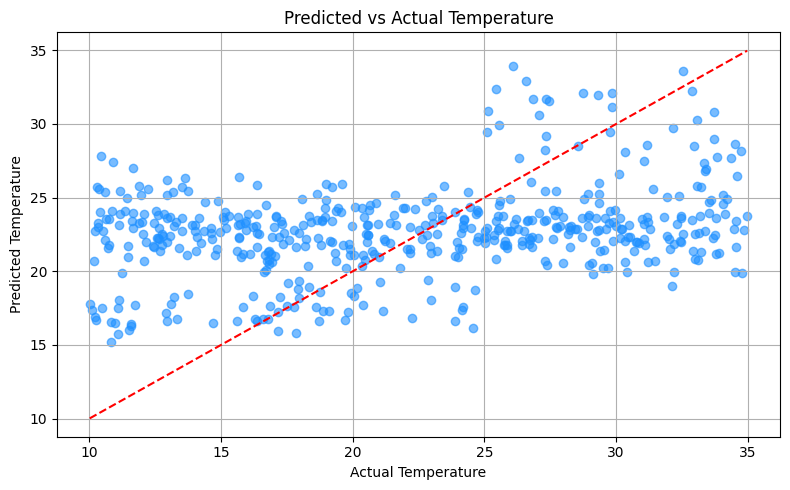

      Actual  Predicted
0  27.313866  28.259411
1  21.033037  19.258102
2  24.114928  22.568850
3  24.210476  23.479691
4  13.079491  23.667515
5  25.998026  22.761292
6  16.445542  22.534241
7  29.696236  20.250652
8  15.945181  22.814373
9  18.845476  23.450397
Predicted Temperature: 17.8700008392334 °C


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error
import matplotlib.pyplot as plt
import pickle
import os

#1. Load and prepare data
train_df = pd.read_csv("../Data/train_data.csv")
test_df = pd.read_csv("../Data/test_data.csv")

#Separate features and target
target_column = "Temperature"
X_train = train_df.drop(columns=[target_column])
y_train = train_df[[target_column]]
X_test = test_df.drop(columns=[target_column])
y_test = test_df[[target_column]]

#2. Create two scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

#Scale features and targets separately
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)

#3. Save scalers and features
os.makedirs("../Artifacts", exist_ok=True)
with open('../Artifacts/temp_scaler.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)

with open('../Artifacts/temp_target_scaler.pkl', 'wb') as f:
    pickle.dump(target_scaler, f)

with open('../Artifacts/temp_features.pkl', 'wb') as f:
    pickle.dump(X_train.columns.tolist(), f)

#4. Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

#5. Define the model
class TemperatureRegressor(nn.Module):
    def __init__(self, input_dim):
        super(TemperatureRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.model(x)

model = TemperatureRegressor(input_dim=X_train.shape[1])

#6. Train the model
def train_regression_model(model, train_dataset, epochs=100, batch_size=32, learning_rate=0.0005):
    model.train()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        epoch_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - Epoch Loss: {epoch_loss:.4f}")

#Calling the trian function
train_regression_model(model, train_dataset)

#7. Evaluate
model.eval()
with torch.no_grad():
    preds_scaled = model(X_test_tensor).numpy()
    predictions = target_scaler.inverse_transform(preds_scaled)

y_test_actual = y_test.values

#8. Metrics
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)
max_err = max_error(y_test_actual, predictions)

print("\n Evaluation Report:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
print(f"Max Error: {max_err:.2f}")

#9. Save model
torch.save(model.state_dict(), "../Artifacts/DeepLearn_model.pt")

#10. Scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(y_test_actual, predictions, alpha=0.6, color='dodgerblue')
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel("Actual Temperature")
plt.ylabel("Predicted Temperature")
plt.title("Predicted vs Actual Temperature")
plt.grid(True)
plt.tight_layout()
plt.show()

#11. Export predictions
comparison = pd.DataFrame({
    "Actual": y_test_actual.flatten(),
    "Predicted": predictions.flatten()
})
comparison.to_csv("../Artifacts/predicted_vs_actual.csv", index=False)
print(comparison.head(10))

#12. Inference Function
def predict_temperature(input_string):
    with open("../Artifacts/temp_scaler.pkl", "rb") as f:
        scaler = pickle.load(f)
    with open("../Artifacts/temp_target_scaler.pkl", "rb") as f:
        target_scaler = pickle.load(f)
    with open("../Artifacts/temp_features.pkl", "rb") as f:
        feature_names = pickle.load(f)

    if isinstance(input_string, str):
        values = [float(x.strip()) for x in input_string.split(",")]
    elif isinstance(input_string, list):
        values = [float(x) for x in input_string]
    else:
        raise ValueError("Input must be a comma-separated string or a list of floats.")

    input_df = pd.DataFrame([values], columns=feature_names)
    input_scaled = scaler.transform(input_df)
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32)

    class TemperatureRegressor(nn.Module):
        def __init__(self, input_dim):
            super(TemperatureRegressor, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 1)
            )
        def forward(self, x):
            return self.model(x)

    model = TemperatureRegressor(input_dim=len(feature_names))
    model.load_state_dict(torch.load("../Artifacts/DeepLearn_model.pt"))
    model.eval()

    with torch.no_grad():
        scaled_pred = model(input_tensor).numpy()
        predicted_temp = target_scaler.inverse_transform(scaled_pred)

    return round(predicted_temp[0][0], 2)

#13. Test Inference
example_input = "89.59264065174611,7.335604391040214,50.50169383291316,1032.378758690279,1"
print(f"Predicted Temperature: {predict_temperature(example_input)} °C")
